# STEP 0: UPLOAD IMAGE

In [2]:
#INSTALL DEEPINVERSE LIBRARY

%%capture
!pip install git+https://github.com/deepinv/deepinv.git

In [3]:
#IMPORT LIBRARY

import torch
import deepinv as dinv
from deepinv.utils import load_url_image, get_image_url
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [4]:
#get the name of gpu if available, if not we work in cpu
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

The image available with the get_image_url function are available hosted here https://huggingface.co/datasets/deepinv/images/tree/main

I. UPLOAD FROM DEVICE

In [ ]:
#UPLOAD THE IMAGE FROM THE DEVICE
#--> upload before the image in the folder of colab and write the exact name

import skimage
img = skimage.io.imread("alpaca.jpeg")

type(img)   #type of the file
img.shape   #shape, ie dimension + number of channel

This is not a good method cause the image is saved as a Numpy array, so to use it i should change the order of dimension

II. UPLOAD FROM GIVEN FOLDER

In [5]:
#UPLOAD THE IMAGE FROM FOLDER
#--> from the folder above i select the image i want to upload

#select the image from folder and create the url
url = get_image_url("cameraman.png")

#pass the url, define size, choose if we want a color or grey image and pass the device
x_gray = load_url_image(url=url, img_size=512, grayscale=True, device=device)

This is a good method cause i already have the image aas a tensor so ready to use it

In [7]:
#CHECK THE INFO OF IMAGE
def get_info(x):
    print('The image has size', x.size())           #image size

    print('The image is a cuda tensor', x.is_cuda)  #if image is a tensor

    print('The image has min and max:', x.min().item(), x_gray.max().item())  #min e max of image

    print('\n')

#The image has size torch.Size([1, 1, 512, 512]). -->  foUr dimension torch tensor with no color channel (grey)
get_info(x_gray)



The image has size torch.Size([1, 1, 512, 512])
The image is a cuda tensor False
The image has min and max: 0.0 1.0




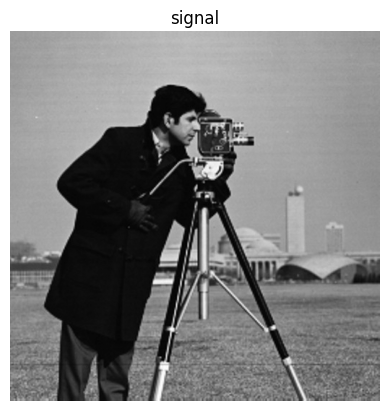

In [8]:
#PLOT IMAGE: STANDARD WAY

#To plot we need to drop the frist two size
plt.imshow(x_gray[0,0,:,:].cpu(), cmap='gray')
plt.title('signal')
plt.axis('off')
plt.show()

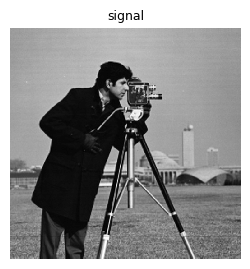

In [9]:
#PLOT IMAGE: DEEPINVERSE

#We pass x_gray: list of images i want to plot
#        "signal": list of labels
dinv.utils.plot([x_gray], ["signal"], figsize=(3,3))

In [ ]:
#UPLOAD COLORED IMAGE

url = get_image_url("CBSD_0010.png")

img_size = 128

x_color = load_url_image(url, img_size=img_size, grayscale=False, device=device)

dinv.utils.plot([x_color], ["signal"], figsize=(3,3))

#The image has size torch.Size([1, 3, 128, 128]). -->  foUr dimension torch tensor with 3 channel (colored)
get_info(x_color)

 III. UPLOAD FROM INTERNET

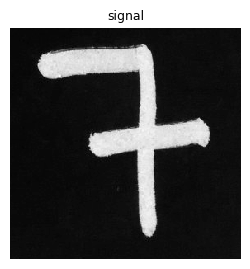

In [16]:
#UPLOAD IMAGE FROM THE INTERNET
url = ("https://i.sstatic.net/fyPhv.jpg")

x_mnist = load_url_image(url=url, img_size=280, grayscale=True, device=device)
x_mnist = 1 - x_mnist #switch to take the negative of the image (black part becomes with and viceversa)

dinv.utils.plot([x_mnist], ["signal"], figsize=(3,3))

In [ ]:
examples = [x_color, x_gray, x_mnist]

for x in examples:
    get_info(x)

# STEP 1: PHYSICS OPERATOR

# STEP 1.0: DEFINE THE NOISE MODEL

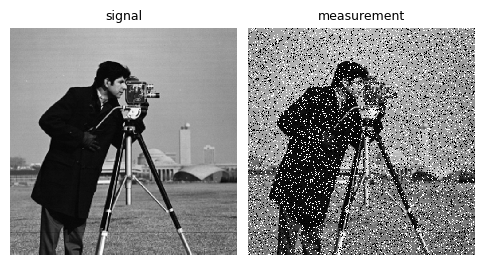

In [11]:
#1. DEFINE THE NOISE DISTRIBUTION: SALT AND PEPPER
noise_distribution = dinv.physics.SaltPepperNoise(p=0.1, s=0.1)

#2. DEFINE THE PHYSICS: DENOISING PROBLEM
physics = dinv.physics.Denoising(noise_distribution)

#3. PASS THE REAL IMAGE
y = physics(x_gray)

#4. PLOT THE CORRUPTED IMAGE
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], figsize=(6,3))

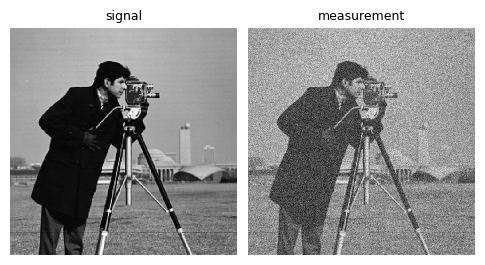

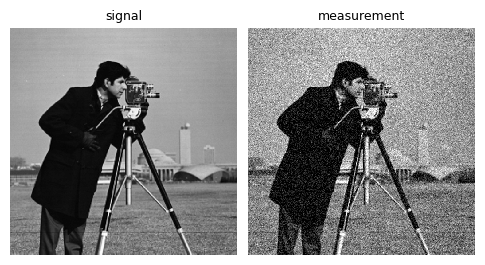

In [12]:
#1. DEFINE THE NOISE DISTRIBUTION: GAUSSIAN
noise_distribution = dinv.physics.GaussianNoise(sigma=0.1)

#2. DEFINE THE PHYSICS: DENOISING PROBLEM
physics = dinv.physics.Denoising(noise_distribution)

#3. PASS THE REAL IMAGE
y = physics(x_gray)

#4. PLOT THE CORRUPTED IMAGE
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], figsize=(6,3))
# rescale_mode='clip': recsale to have the gray level between 0 (white) and 1 (black)
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], rescale_mode='clip', figsize=(6,3))

In [ ]:
#1. DEFINE THE NOISE DISTRIBUTION: POISSON
noise_distribution = dinv.physics.PoissonNoise(gain=0.1)

#2. DEFINE THE PHYSICS: DENOISING PROBLEM
physics = dinv.physics.Denoising(noise_distribution)

#3. PASS THE REAL IMAGE
y = physics(x_gray)

#4. PLOT THE CORRUPTED IMAGE
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], figsize=(6,3))
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], rescale_mode='clip', figsize=(6,3))

In [14]:
noise_model=dinv.physics.GaussianNoise(sigma=0.01)

# STEP 1.1: DEFINE THE OPERATOR


In [ ]:
#INPAINTING OPERATOR

#We have to pass: size of image, mask (1/2 of pixel), the noise
physics = dinv.physics.Inpainting((1, 512, 512), mask = 0.5, \
                                    noise_model=noise_model,\
                                    device = device)

y = physics(x_gray)
dinv.utils.plot([x_gray, y], titles=["signal", "measurement"], rescale_mode='clip', figsize=(6,3))

In [ ]:
#BLUR OPERATOR

#DEFINE THE FILTER (MASK): GAUSSIAN BLUR
#--> pass inside the blur func the gaussian_blur
#--> define sigma: spread of gaussian blur in the x (1) and y (4) direction (blur lungo 1 alto 4)
#           angle: rotation angle of gaussian blur

filter = dinv.physics.blur.gaussian_blur(sigma=(1, 4), angle=45)

#padding='circular': can change the padding by looking the possibility in documentation
physics = dinv.physics.Blur(filter,padding='circular', \
                            noise_model=noise_model,\
                            device=device)

y = physics(x_gray)
dinv.utils.plot([filter, x_gray, y], ["filter","signal", "measurement"], rescale_mode='clip', figsize=(6,3))

In [ ]:
#BLUR FFT OPERATOR

physics = dinv.physics.BlurFFT(filter=filter, img_size=(1, 512, 512),\
                            noise_model=noise_model,\
                                device=device)

y = physics(x_gray)
dinv.utils.plot([filter, x_gray, y], ["filter","signal", "measurement"], rescale_mode='clip')

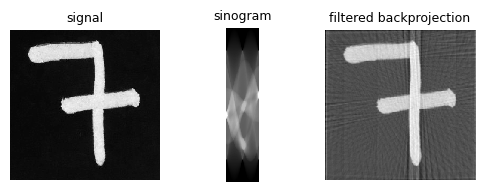

In [17]:
#TOMOGRAPHY OPERATOR: RADON TRASFORM

#--> In Radon we have a source of x-ray, and a detector. The detector has a certein num of recivers:
#    for each recivers we compute the integral along the line connecting the source with the detector
#    to obtain the mass along this line, and then rotate for each angle and compute again the integral


# img_width: number of recivers (image with parameter)
# angles: number of angles


#DEFINE NUM OF ANGLES
# more steps --> more angles --> better quality of reconstruct image
angles = torch.linspace(0,179,steps=60)

physics = dinv.physics.Tomography(angles=angles, img_width=200, circle=False, noise_model=noise_model, device=device)

y = physics(x_mnist)
dinv.utils.plot(
    [x_mnist, (y - y.min()) / y.max(), physics.A_dagger(y)],
    titles=["signal", "sinogram", "filtered backprojection"],
)

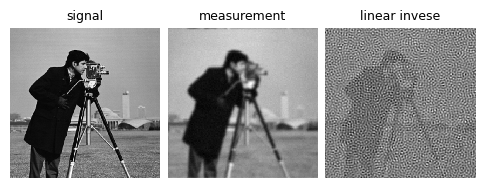

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 128, 128])


In [18]:
#DOWNSAMPLING OPERATOR

#DEFINE FILTER
filter = dinv.physics.blur.gaussian_blur(sigma=(2, 2), angle=0)

# filter="gaussian": define filter automatically
# filter=filter: define filter manually as above
# factor=4: how we want to reduce the image
#.          --> take 1 pixel for each 4, so the final output has size 1/4 the size of initial one
physics = dinv.physics.Downsampling(img_size=(1, 512, 512), filter="gaussian", factor=4,\
                                    noise_model=noise_model, device=device)


y = physics(x_gray)

#PLOT
# x_gray: original image
# y: reconstruct image
# physics.A_dagger(y): dummy reconstruction obtained by pseudo inverse of deep inverse
dinv.utils.plot([x_gray, y, physics.A_dagger(y)], titles=["signal", "measurement", "linear invese"], figsize=(6,3))

print(x_gray.size())
print(y.size())

In [ ]:
#DECOLORIZE OPERATOR

physics = dinv.physics.Decolorize(device=device)

y = physics(x_color)

# plot results
dinv.utils.plot([x_color, y, physics.A_dagger(y)], titles=["signal", "measurement", "linear inverse"])